### Exploratory Data Analysis Notebook

This python notebook aims to perform initial exploratory data analysis in order to understand the high level trends present in the data and form initial conclusions regarding the modelling approach

#### Import statements

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import yaml
import random

#### Configuration Parameters

In [ ]:
dataset_root = os.path.join("..", "data")
split = "train"  # only train for EDA
num_classes = 12
exts = [".jpg", ".jpeg", ".png"]
min_box_size = 0.01  # relative to image (YOLO coords)

#### Helper Functions

In [ ]:
with open(os.path.join(dataset_root, "data.yaml"), "r") as f:
    data_cfg = yaml.safe_load(f)

class_names = [n.strip() for n in data_cfg["names"]]   # preserves ordering
num_classes = len(class_names)

# build robust mapping: plural and singular forms -> same index
class_lookup = {}
for idx, name in enumerate(class_names):
    key = name.lower().strip()
    class_lookup[key] = idx
    # add singular if endswith 's' and it's not a double-s (rare)
    if key.endswith("s") and not key.endswith("ss"):
        class_lookup[key[:-1]] = idx
    # also add a version without punctuation
    class_lookup["".join(ch for ch in key if ch.isalpha())] = idx
class_lookup["catterpillar"] = class_lookup.get("caterpillars", None)

# reverse mapping index -> canonical display name (use YAML name)
index_to_name = {i: class_names[i] for i in range(num_classes)}

In [ ]:
def find_image_for_label(label_file, images_dir):
    #Find image that corresponds to label_file. tolerant to extension differences and small name variants
    
    base = os.path.splitext(os.path.basename(label_file))[0]

    for ext in exts:
        p = os.path.join(images_dir, base + ext)
        if os.path.exists(p):
            return p
        
    return None

In [ ]:
def find_label_for_image(image_file, labels_dir):
    base = os.path.splitext(os.path.basename(image_file))[0]
    candidate = os.path.join(labels_dir, base + ".txt")
    return candidate if os.path.exists(candidate) else None

def filename_prefix_to_expected_index(filename):
    """Take filename or path and return canonical prefix token + corresponding class index (or None)."""
    base = os.path.splitext(os.path.basename(filename))[0]
    prefix = base.split("-")[0].strip().lower()
    prefix_alpha = "".join(ch for ch in prefix if ch.isalpha())

    # try several fallbacks
    for key in (prefix, prefix_alpha):
        if key in class_lookup:
            return class_lookup[key]
        
    # try removing trailing 's' if present
    if prefix.endswith("s"):
        sing = prefix[:-1]
        if sing in class_lookup:
            return class_lookup[sing]
        
    return None

def parse_labels(labels_dir):
    """
    Parse all YOLO label files.
    Returns:
      - boxes: list of dicts {file, class, x,y,w,h}
      - file_classes: dict filename -> set(class_ids) (unique per file)
    """
    boxes = []
    file_classes = defaultdict(set)
    for root, _, files in os.walk(labels_dir):
        for f in files:
            if not f.endswith(".txt"):
                continue
            p = os.path.join(root, f)
            with open(p, "r") as fh:
                for line in fh:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    if len(parts) < 5:
                        continue
                    try:
                        cls = int(parts[0])
                        x, y, w, h = map(float, parts[1:5])
                    except Exception:
                        continue
                    boxes.append({"file": f, "class": cls, "x": x, "y": y, "w": w, "h": h})
                    file_classes[f].add(cls)
    return boxes, file_classes

##### EDA Functions

In [ ]:
def class_distribution(labels_dir, mode="box", show_plot=True):
    """
    mode:
      'box' -> count every bounding box
      'file' -> for each file, count each unique class once 
    """
    boxes, file_classes = parse_labels(labels_dir)

    if mode == "box":
        counts = Counter([b["class"] for b in boxes])
    elif mode == "file":
        counts = Counter()
        for fname, cls_set in file_classes.items():
            for cls in cls_set:
                counts[cls] += 1
    else:
        raise ValueError("mode must be 'box' or 'file'")

    # include zero-count classes
    counts_full = {i: counts.get(i, 0) for i in range(num_classes)}

    if show_plot:
        labels = [index_to_name[i] for i in range(num_classes)]
        values = [counts_full[i] for i in range(num_classes)]

        # Portrait-style dimensions for IEEE column formatting
        plt.figure(figsize=(5, 5), dpi=200)

        bars = plt.bar(labels, values)

        # IEEE-readable text sizes
        plt.xticks(rotation=60, ha="right", fontsize=12)
        plt.yticks(fontsize=12)

        plt.ylabel(
            "Count ({})".format("boxes" if mode == "box" else "files-with-class"),
            fontsize=12
        )

        plt.xlabel(
            "Pest Class",
            fontsize=12
        )

        plt.title(
            f"Bounding Box Distribution by Class",
            fontsize=14,
        )

        plt.tight_layout()
        plt.show()

    return counts_full

def bbox_statistics_from_boxes(boxes):
    widths = np.array([b["w"] for b in boxes])
    heights = np.array([b["h"] for b in boxes])
    areas = widths * heights
    aspect_ratios = widths / (heights + 1e-12)
    small_objects = np.sum(areas < 0.01)
    print(f"Total boxes: {len(boxes)}, Small-object boxes (<1% image area): {small_objects} ({small_objects/len(boxes)*100:.2f}%)")
    plt.figure(figsize=(5,5), dpi=200)
    plt.subplot(1,3,1); plt.hist(widths, bins=30); plt.title("BBox widths (relative)")
    plt.subplot(1,3,2); plt.hist(heights, bins=30); plt.title("BBox heights (relative)")
    plt.subplot(1,3,3); plt.hist(aspect_ratios, bins=30); plt.title("BBox width/height ratios")
    plt.tight_layout()
    plt.show()

def spatial_distribution_from_boxes(boxes):
    xs = [b["x"] for b in boxes]; ys = [b["y"] for b in boxes]
    plt.figure(figsize=(6,6)); plt.hist2d(xs, ys, bins=80); plt.colorbar(label='Number of box')
    plt.xlabel('X center (relative)', fontsize=12)
    plt.ylabel('Y center (relative)', fontsize=12)
    plt.title('Spatial distribution of bbox centers')
    plt.tight_layout()
    plt.show()

def objects_per_image(boxes):
    counts = Counter([b["file"] for b in boxes])
    plt.figure(figsize=(10,4)); plt.hist(list(counts.values()), bins=range(1, max(counts.values())+2))
    plt.xlabel("Objects per image"); plt.ylabel("Number of images"); plt.title("Objects per image distribution"); plt.show()
    return counts

def image_quality_analysis(images_dir, boxes):
    widths, heights, brightness, contrast = [], [], [], []
    files_seen = set([b["file"] for b in boxes])
    for f in files_seen:
        # find image path from label file name
        # label filename f -> label path unknown here, so attempt to find by scanning images_dir for startswith f.split('.')[0]
        label_base = os.path.splitext(f)[0]
        img_path = None
        for ext in exts:
            cand = os.path.join(images_dir, label_base + ext)
            if os.path.exists(cand):
                img_path = cand; break
        if img_path is None:
            # try more tolerant matching
            for fn in os.listdir(images_dir):
                if fn.startswith(label_base.split(".rf")[0]):
                    img_path = os.path.join(images_dir, fn); break
        if img_path is None:
            continue
        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w = img.shape[:2]
        widths.append(w); heights.append(h)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness.append(np.mean(gray)); contrast.append(np.std(gray))
        
    plt.figure(figsize=(15,4))
    plt.subplot(1,4,1)
    plt.hist(widths, bins=20); plt.title("Image widths (px)")
    plt.subplot(1,4,2)
    plt.hist(heights, bins=20); plt.title("Image heights (px)")
    plt.subplot(1,4,3)
    plt.hist(brightness, bins=20); plt.title("Mean brightness")
    plt.subplot(1,4,4)
    plt.hist(contrast, bins=20); plt.title("Contrast (std dev)")
    plt.tight_layout()
    plt.show()

def bbox_avg_per_class(boxes, index_to_name):
    #Compute average bounding box statistics per class.

    class_boxes = defaultdict(list)
    for b in boxes:
        class_boxes[b["class"]].append(b)
    
    avg_stats = {}
    for cls_idx, cls_boxes in class_boxes.items():
        widths = np.array([b["w"] for b in cls_boxes])
        heights = np.array([b["h"] for b in cls_boxes])
        areas = widths * heights
        aspect_ratios = widths / (heights + 1e-12)
        
        avg_stats[cls_idx] = {
            "mean_width": widths.mean(),
            "mean_height": heights.mean(),
            "mean_area": areas.mean(),
            "mean_aspect_ratio": aspect_ratios.mean(),
            "num_boxes": len(cls_boxes)
        }
    
    # Print summary
    print("Average bbox stats per class:")
    for cls_idx, stats in avg_stats.items():
        print(f"{index_to_name[cls_idx]} ({stats['num_boxes']} boxes): "
              f"Width={stats['mean_width']:.3f}, Height={stats['mean_height']:.3f}, "
              f"Area={stats['mean_area']:.4f}, Aspect Ratio={stats['mean_aspect_ratio']:.3f}")
    
    return avg_stats

#### EDA Run

In [ ]:
labels_dir = os.path.join(dataset_root, split, "labels")
images_dir = os.path.join(dataset_root, split, "images")

boxes, file_classes = parse_labels(labels_dir)
print("Parsed boxes:", len(boxes), "files:", len(file_classes))

Parsed boxes: 15188 files: 11462


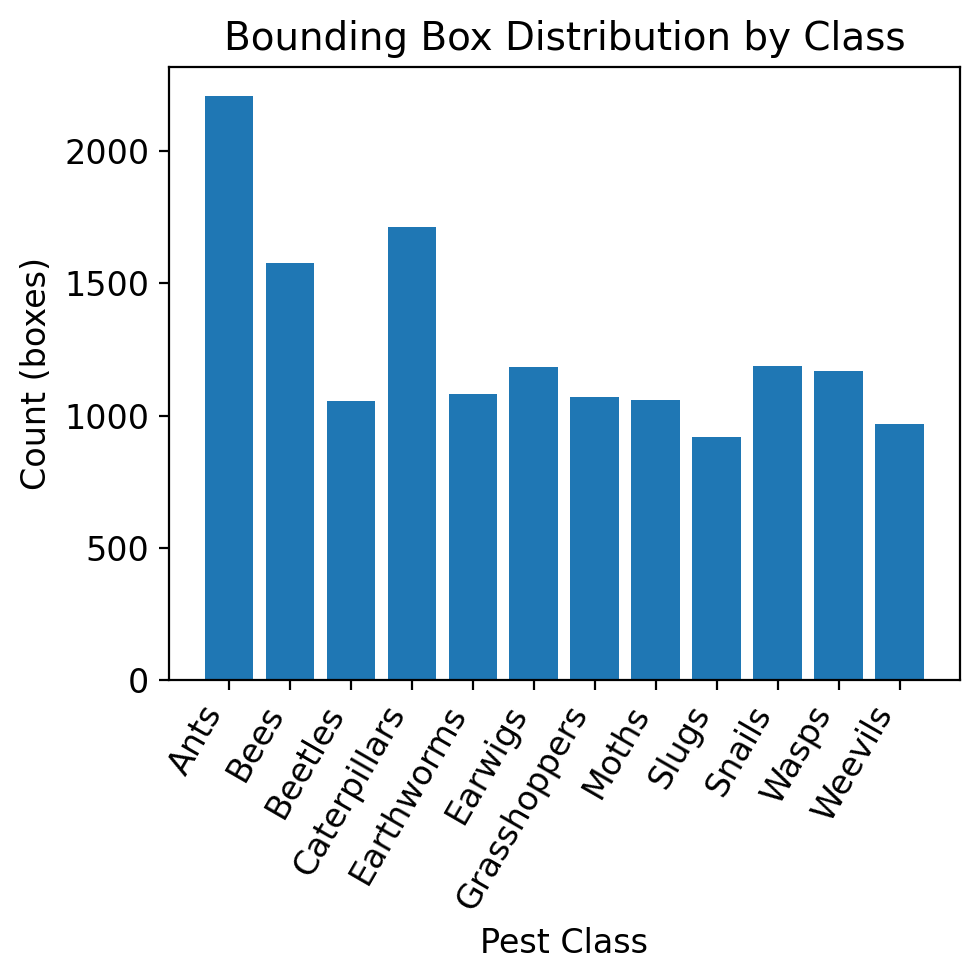

In [ ]:
dist_box = class_distribution(labels_dir, mode="box", show_plot=True)

Total boxes: 15188, Small-object boxes (<1% image area): 721 (4.75%)


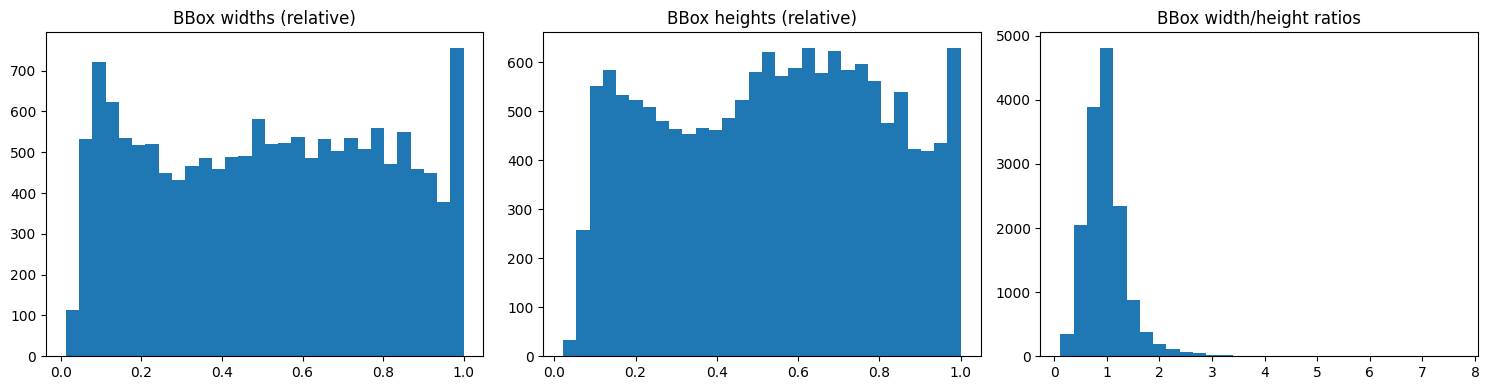

In [19]:
bbox_statistics_from_boxes(boxes)

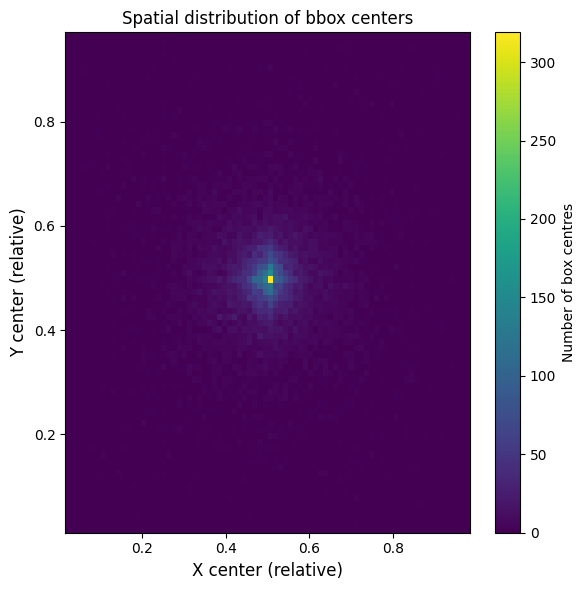

In [32]:
spatial_distribution_from_boxes(boxes)

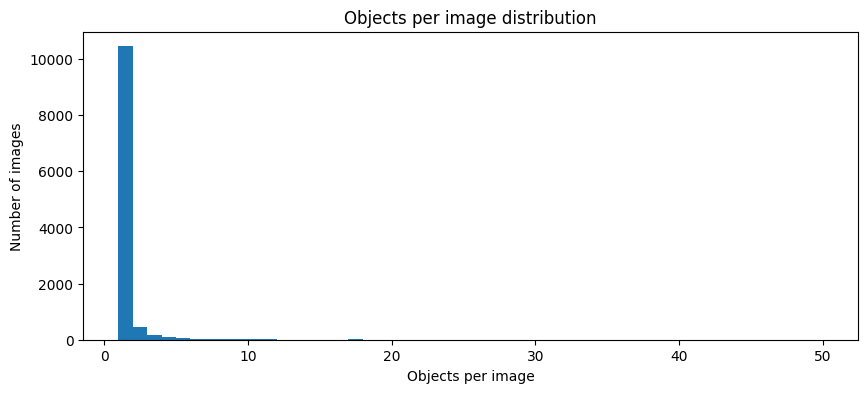

In [21]:
obj_counts = objects_per_image(boxes)

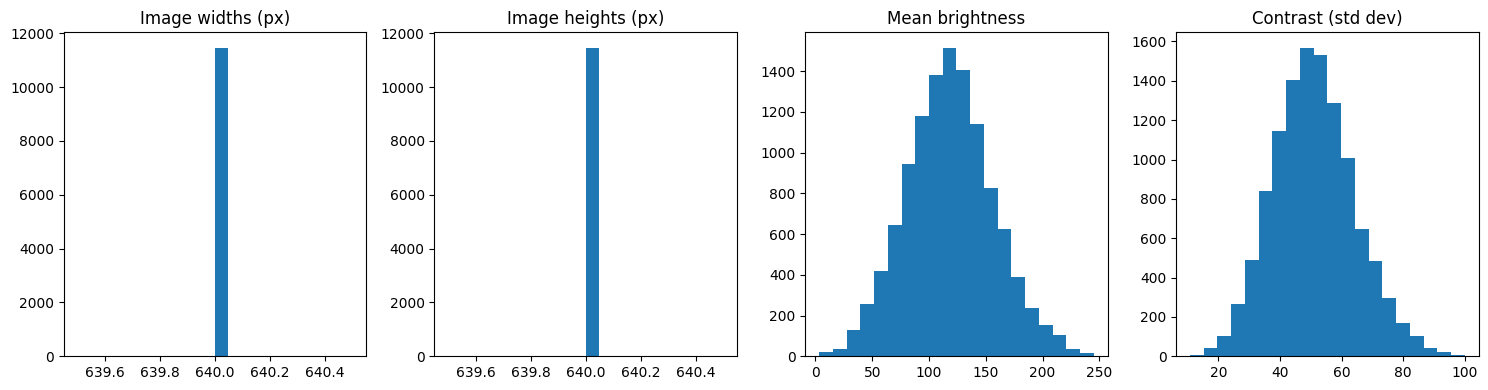

In [22]:
image_quality_analysis(images_dir, boxes)

In [24]:
avg_bbox_stats = bbox_avg_per_class(boxes, index_to_name)

Average bbox stats per class:
Ants (2208 boxes): Width=0.325, Height=0.375, Area=0.1699, Aspect Ratio=0.879
Bees (1575 boxes): Width=0.371, Height=0.432, Area=0.2071, Aspect Ratio=0.863
Beetles (1055 boxes): Width=0.439, Height=0.469, Area=0.2636, Aspect Ratio=0.925
Wasps (1167 boxes): Width=0.696, Height=0.705, Area=0.5287, Aspect Ratio=1.009
Caterpillars (1714 boxes): Width=0.351, Height=0.383, Area=0.1788, Aspect Ratio=0.986
Earthworms (1083 boxes): Width=0.469, Height=0.462, Area=0.2552, Aspect Ratio=1.156
Earwigs (1182 boxes): Width=0.542, Height=0.541, Area=0.3576, Aspect Ratio=1.014
Grasshoppers (1071 boxes): Width=0.598, Height=0.674, Area=0.4323, Aspect Ratio=0.921
Moths (1059 boxes): Width=0.821, Height=0.825, Area=0.6846, Aspect Ratio=1.012
Slugs (918 boxes): Width=0.576, Height=0.542, Area=0.3404, Aspect Ratio=1.155
Snails (1187 boxes): Width=0.623, Height=0.606, Area=0.4016, Aspect Ratio=1.064
Weevils (969 boxes): Width=0.739, Height=0.736, Area=0.5650, Aspect Ratio=1.030
